# Variational Auto-Encoder using Normalizing Flows
Abhimanyu Talwar, Julien Laasri, and Nick Feng

# Problem Statement
The problem at hand involves doing approximate inference on latent variable models. A Variational Auto-Encoder (VAE) allows us to approximate two distributions of interest:
* **Posterior Distribution**: Represented by $p_{Z|X}(\cdot)$ where $Z$ is the latent variable and $X$ is the observed variable.
  * **Why do we want the Posterior?** For one, learning about the latent variable, tells us something about the underlying data generation process. Further, a latent variable representation is often a compact representation of high dimensional data, which can be useful. 
  * **Why approximate?** The reason exact inference is sometimes hard for the Posterior is because computing the partition function $\mathcal{Z} = \sum_z p(x,z)$ is computationally expensive. We have $p_(z|x) = \frac{p(x,z)}{\sum_z p(x,z)}$. And thus we resort to approximating the Posterior via another distribution  $q_{\theta}(z|x)$. 
  * **How does a VAE represent the Posterior?** In a VAE, $q(\cdot)$ is parametrized by a neural network (called the "inference network" or "encoder"). We can write the distribution as follows (here $g_{\theta}(x)$ represents a neural network with two outputs - $\mu$ and $\log{\Sigma}$):
$$q_{\theta}(z|x) \sim \mathcal{N}\left(g_{\theta}(x)^{\mu}, g_{\theta}(x)^{\Sigma}\right)$$

* **Generative Distribution**: Represented by $p_{X|Z}(\cdot)$, this basically defines the data generating process. 
 * **Why do we want the Generative Distribution?** It allows us to draw samples of the random variable $X$.
 * **Why approximate?** Pretty much for the same reason for which we had to approximate the Posterior - if computing the partition function $\mathcal{Z}$ is intractable, we cannot compute the probability density for $X$.
 * **How does a VAE represent the posterior?** In a VAE, this is represented by $p_{\phi}(x|z)$ and parametrized by another neural network called the "generative network" or the "decoder". Again, we define the distribution as follows (here $h_{\phi}$ represents the neural network):
$$p_{\phi}(z|x) \sim \mathcal{N}\left(h_{\phi}(z), \mathbb{I}\right)$$

## Paper's Contribution
Usually one would approximate the posterior using a Gaussian distribution (as is described above) and in cases where the latent variable distribution is different from a Gaussian (e.g. when it's a multi-modal distribution), then the expressive ability of the approximate Posterior and Generative models will be limited. In the paper [Rezende, Mohamed, 2016], the authors introduce a method for specifying arbitrarily complex distributions using Normalizing Flows, which can get past this issue.


The VAE based on Normalizing Flows comprises of an Encoder, a Flow Network, and a Decoder. The network is optimized end-to-end by maximizing the Evidence Lower Bound.

In [0]:
import torch.nn as nn
import torch
import sys
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
def tensorlist_to_tensor(l):
    return torch.cat([t.unsqueeze(0) for t in l])

# Flow Network
For this project, we have implemented Planar Flows as described in Rezende, Mohamed 2016. The basic building block of Planar Flows is this transformation (Here $h$ is a non-linear function - we have used the hypbolic tangent, and $\mathbb{u}, \mathbb{w}, b$ are parameters which are learnt from data. Further, $z$ is the random variable whose distribution we want to transform using $f(\cdot)$):

$$f(z) = z + \mathbb{u}h\left(\mathbb{w}^Tz + b\right)$$

Our Flow Network composes a series of these $f(\cdot)$'s.

In [0]:
class Flow(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.K = K
        self.linear_layers = nn.ModuleList([nn.Linear(D, 1) for _ in range(K)])
        self.u_vectors = nn.Parameter(data=torch.empty(K,D).uniform_(-0.01,0.01))

    def _init_weights(self):
        for layer in self.linear_layers:
            layer.weight.data.uniform_(-0.01, 0.01)
            layer.bias.data.uniform_(-0.01, 0.01)
    
    def forward(self, z):
        all_zs = [z]
        all_u_times_psis = []
        for linear_layer, u_vector in zip(self.linear_layers,
                                          self.u_vectors):
            z_prev = all_zs[-1]
            linear_layer_output = linear_layer(z_prev)
            tanh_output = torch.tanh(linear_layer_output)
            all_zs.append((z_prev + u_vector * tanh_output))
            all_u_times_psis.append(torch.sum(u_vector * (1 - tanh_output**2) * linear_layer.weight, dim=1))
        # return tensorlist_to_tensor(all_zs), tensorlist_to_tensor(all_u_times_psis)
        return all_zs, tensorlist_to_tensor(all_u_times_psis).permute(1, 0)

# Inference Network (Also known as the Encoder)
We havse used a series of Affine and ReLU non-linearity layers for our Inference Network. It has two outputs: $\mu$ and $\log diag(\Sigma)$, which are the mean and log-variance of the distribution of $Z$. 

In [0]:
class InferenceNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, n, D):
        super().__init__()
        self.linear_layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)] +\
                                           [nn.Linear(hidden_dim, hidden_dim) for _ in range(n)])
        self.mu_layer = nn.Linear(hidden_dim, D)
        self.logvar_layer = nn.Linear(hidden_dim, D)
    
    def forward(self, x):
        h = x
        for ll in self.linear_layers:
            h = torch.relu(ll(h))
        return self.mu_layer(h), self.logvar_layer(h)

# Generative Network (Also known as the Decoder)
Our Decoder architecture is similar to our Encoder architecture (a series of Affine and ReLU layers), except that there is only one output - the reconstructed $X$.

In [0]:
class GenerativeNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, n, D):
        super().__init__()
        self.linear_layers = nn.ModuleList([nn.Linear(D, hidden_dim)] + \
                                           [nn.Linear(hidden_dim, hidden_dim) for _ in range(n)])
        self.reconstruction_layer = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        h = x
        for ll in self.linear_layers:
            h = torch.relu(ll(h))
        return self.reconstruction_layer(h)

# Complete VAE (combines Encoder, Flows, and the Decoder)

In [0]:
class CompleteNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, D, K, n_layers, alpha):
        super().__init__()
        self.inference_net = InferenceNetwork(input_dim, hidden_dim, n_layers, D)
        self.flow_net = Flow(K, D)
        self.generative_net = GenerativeNetwork(input_dim, hidden_dim, n_layers, D)
        self.alpha = alpha
    
    def _sample(self, mu, logvar):
        return mu + (0.5*torch.exp(logvar))*torch.randn_like(mu)

    def forward(self, x):
        mu, logvar = self.inference_net(x)
        z = self._sample(mu, logvar)
        all_zs, all_u_times_psis = self.flow_net(z)
        z_K = all_zs[-1]
        reconst_x = self.generative_net(z_K)

        log_q0 = torch.mean(torch.sum(-.5 * logvar - .5 * (z - mu) ** 2 / torch.exp(logvar), dim=1))
        log_joint = torch.mean(torch.sum(-.5 * z_K ** 2, dim=1) - torch.sum((reconst_x - x) ** 2, dim=1))
        log_flow = torch.mean(torch.sum(torch.log(torch.abs(1 + all_u_times_psis) + 1e-6), dim=1))

        loss = log_q0 - self.alpha * log_joint - log_flow
        return loss, log_q0, log_joint, log_flow

# Data for Training VAE
We generate a mixture of three Gaussians with different means and variances. The latent variables are:
* Categorical Probabilities $\pi = [c_1,c_2,c_3]$
* Gaussian Means $\mu = [\mu_1, \mu_2, \mu_3]$
* Gaussian variances $\sigma = [\sigma_1, \sigma_2, \sigma_3]$

We generate 5000 samples to train our VAE on.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [0]:
# Mixture of Gaussians
N = 5000
K = 3
pis = [0.2, 0.6, 0.2]
mus = [.3, -.2, 0]
variances = [0.05**2, 0.07**2, 0.05**2]
# variances = [1.0, 1.0, 1.0]

zs = np.random.choice(np.arange(K), size=N, p=pis)
y = np.array([np.random.normal(mus[z], variances[z]**0.5, 1)[0] for z in zs])

In [0]:
def plot_mixture_hist(zs,y):
    fig, ax = plt.subplots()
    unique_zs = np.unique(zs)
    for z in unique_zs:
        sns.distplot(y[zs == z], bins=100, ax=ax)
    fig.set_size_inches(12,7)

def plot_mixture_scatter(zs,y):
    fig, ax = plt.subplots()
    unique_zs = np.unique(zs)
    for z in unique_zs:
        sns.scatterplot(x=y[zs==z,0], y=y[zs==z,1])
    fig.set_size_inches(12,7)

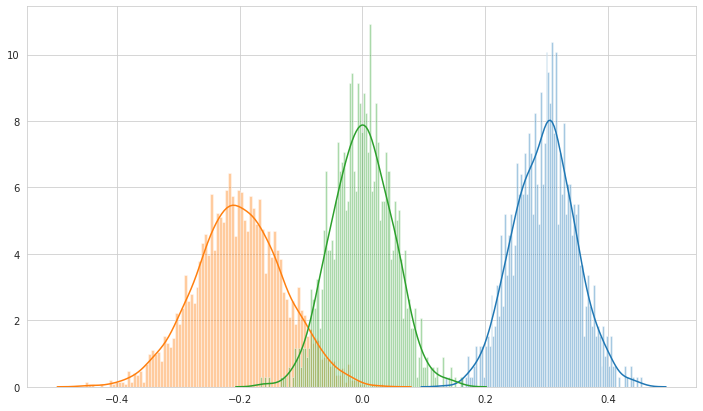

In [0]:
plot_mixture_hist(zs, y)

In [0]:
tensor_y = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)
tensor_y.shape

torch.Size([5000, 1])

# Training
The VAE involves a large number of hyper-parameters (number of layers in Inference, Flow, Generative networks, choice of non-linearities, choice of parameter initializations, number of Normalizing Flow layers, and the usual training related hyper-parameters such as choice of optimizer, learning rates etc.) Our final hyperparameter choices are shown in the cell below: 

In [0]:
model_config = {
    'input_dim': 1, 
    'hidden_dim': 16, 
    'D': 8, 
    'K': 16, 
    'n_layers': 4,
    'alpha': 1.0,
}

model = CompleteNet(**model_config)
model.to(device);
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
num_epochs = 1000
batch_size = 1024
update_freq = 100
num_batches = int(tensor_y.shape[0]/batch_size)
for epoch in range(num_epochs):
    t0 = time.time()
    indices = np.random.choice(np.arange(tensor_y.shape[0]), 
                               size=tensor_y.shape[0],
                               replace=False)
    epoch_loss = 0.0
    running_loss = 0.0
    
    for b in range(num_batches): 
        loss, log_q0, log_joint, log_flow = model(tensor_y[b*batch_size:(b+1)*batch_size,:])
        optimizer.zero_grad()
        loss.backward()
        epoch_loss += loss.item()
        running_loss += loss.item()
        optimizer.step()
        if epoch == 0 or epoch % update_freq == update_freq-1 and b%2 == 0:
            if b == 0:
                prefix = '\n'
            else:
                prefix = '\r'
            sys.stdout.write(prefix + f'Epoch {epoch+1} Batch {b+1}/{num_batches} Loss {running_loss:.2f} Time {time.time()-t0:.1f}s')
            running_loss = 0
    if epoch == 0 or epoch % update_freq == update_freq-1:
        sys.stdout.write(prefix + f'Epoch {epoch+1} Batch {b+1}/{num_batches} Loss {epoch_loss/num_batches:.2f}  Time {time.time()-t0:.1f}s')
        # print(f'Epoch {epoch+1} Loss {epoch_loss/num_batches:.3f} Log_q0 {log_q0:.3f} Log_joint {log_joint:.3f} Log_flow {log_flow:.3f}')


Epoch 1 Batch 4/4 Loss -15.04  Time 0.1s
Epoch 100 Batch 4/4 Loss -23.99  Time 0.1s
Epoch 200 Batch 4/4 Loss -24.68  Time 0.1s
Epoch 300 Batch 4/4 Loss -24.94  Time 0.1s
Epoch 400 Batch 4/4 Loss -25.22  Time 0.1s
Epoch 500 Batch 4/4 Loss -25.51  Time 0.1s
Epoch 600 Batch 4/4 Loss -25.56  Time 0.1s
Epoch 700 Batch 4/4 Loss -25.59  Time 0.1s
Epoch 800 Batch 4/4 Loss -25.59  Time 0.1s
Epoch 900 Batch 4/4 Loss -25.62  Time 0.1s
Epoch 1000 Batch 4/4 Loss -25.62  Time 0.1s

# Results: Generated Samples
The plot below shows samples generated by our Decoder after 20k epochs of training the VAE. We see that while we are able to generate a tri-modal distribution, which are similar to the mixture of three Gaussian we had used to generate training data, the model still falls short of learning the latent variables perfectly. Specifically:

* The locations three modes are different from the true means $[-0.3, 0.0, 0.2]$.
* The categorical probabilities are not learnt - the true probabiities corresponding to the means above were $[0.2, 0.6, 0.2]$

In [0]:
num_generate = 3000
z0 = torch.randn(num_generate, model_config["D"])
all_zs, _ = model.flow_net(z0.cuda())
zK = all_zs[-1]
x = model.generative_net(zK).cpu().detach().numpy().flatten()

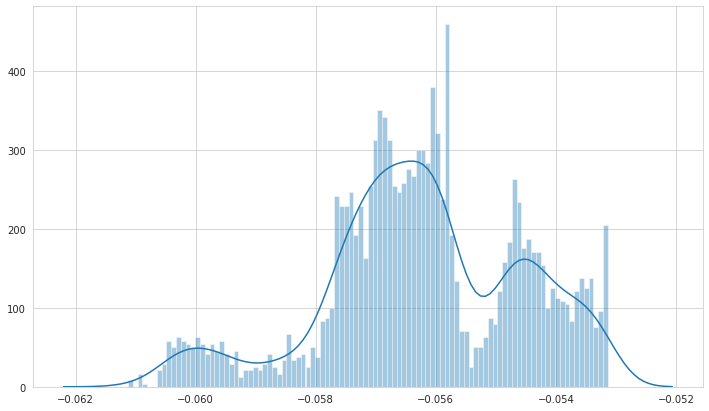

In [0]:
plot_mixture_hist(np.ones(num_generate), x)

# Conclusion and Further Work
While we failed to accurately learn the data generating process, we weren't able to search the hyperparameter space exhaustively. So for future work on this:

* We could tune the weights assigned to terms related to reconstruction and regularization losses.
* We could do a more exhaustive search on architecture parameters such as number of layers, number of hidden nodes etc.